In [73]:
import numpy as np
import pandas as pd 
import statsmodels.formula.api as smf
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.stats.api import anova_lm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
import matplotlib as mpl
import matplotlib.pyplot as plt
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr, data
from rpy2.robjects.packages import importr
pandas2ri.activate()
vgam = importr('VGAM')
stats4 = importr('stats4')
splines = importr('splines')
base = importr("base")


In [74]:
data = pd.read_csv("data.csv")

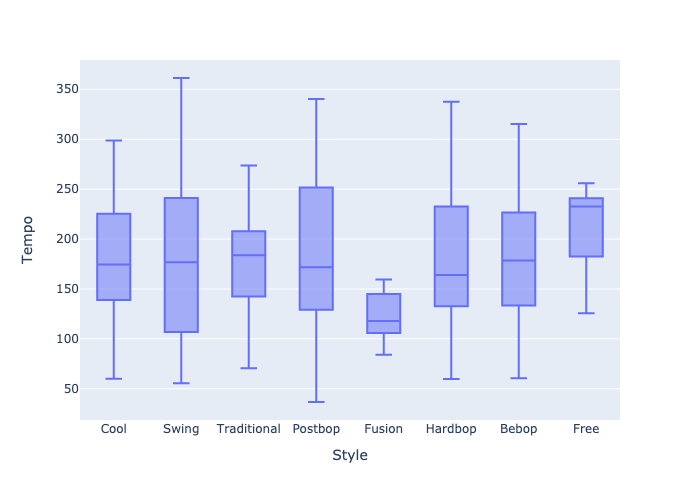

In [75]:
fig1 = px.box(data,x="Style",y="Tempo")
fig1.show("png")

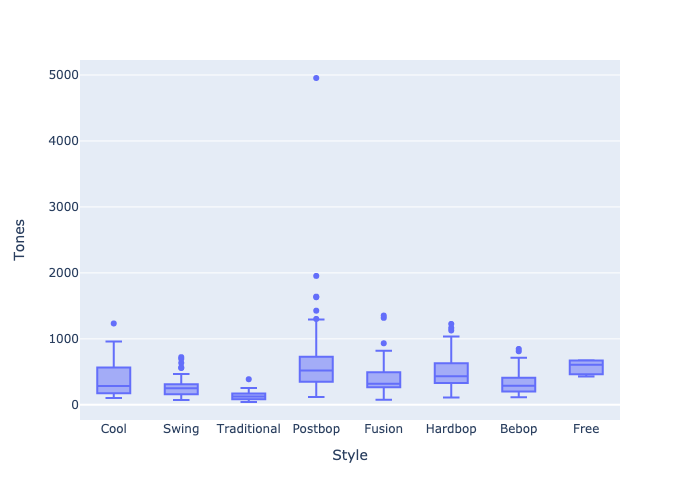

In [76]:
fig2 = px.box(data,x="Style",y="Tones")
fig2.show("png")

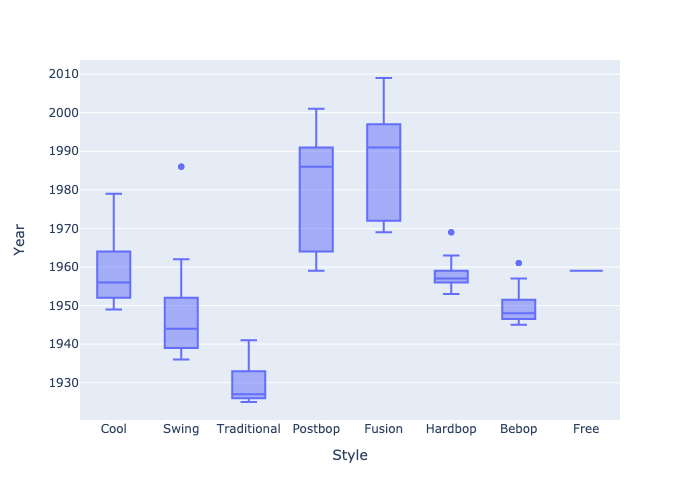

In [77]:
fig3 = px.box(data,x="Style",y="Year")
fig3.show("png")

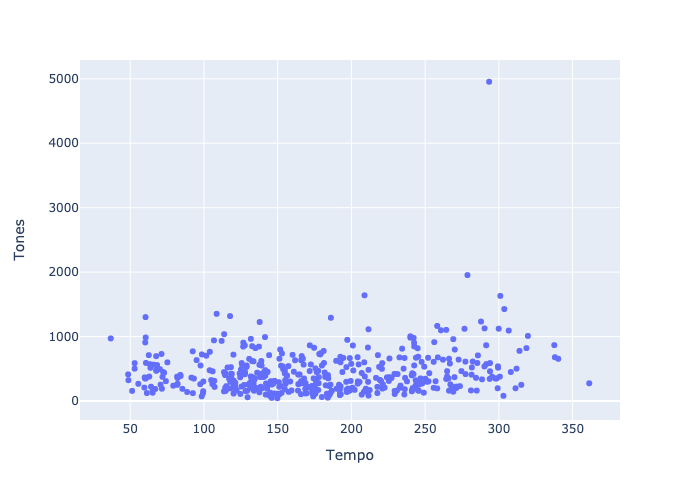

In [78]:
px.scatter(data,x="Tempo",y="Tones").show("png")

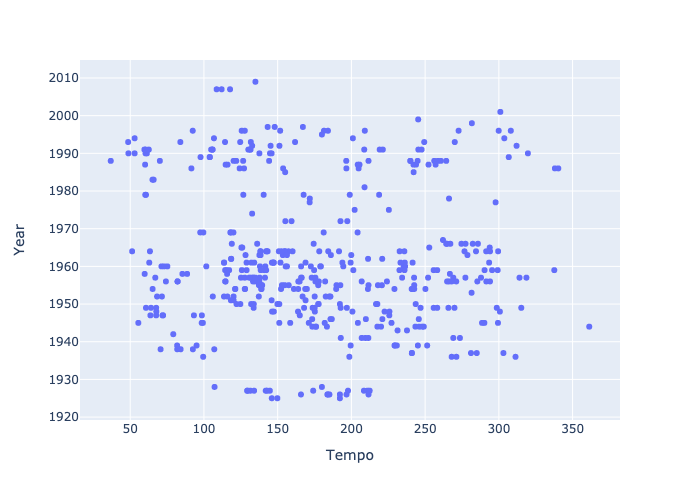

In [79]:
px.scatter(data,x="Tempo",y="Year").show("png")


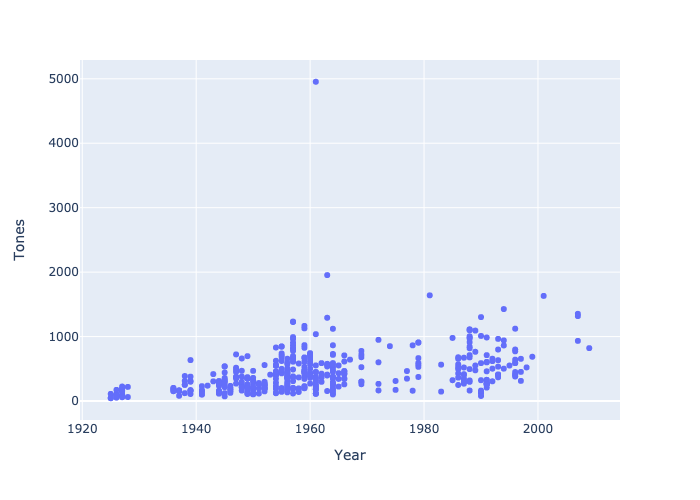

In [80]:
px.scatter(data,x="Year",y="Tones").show("png")

Maybe slight correlation between Tones and Year? This makes sense since audio clarity in speakers and fidelity in recording equipment has improved over the years. Maybe jazz musicians have also gotten more expressive and experimental with certian songwriting, recording and arrangement techniques.

In [81]:
data["Year"].corr(data["Tones"])

0.3866235236784666

Not a very strong correlation, however.

In [82]:
year = pd.to_numeric(data["Year"])
tones = pd.to_numeric(data["Tones"])
tempo = pd.to_numeric(data["Tempo"])

data["Style"].value_counts()
style=data["Style"]

In [83]:
df = pd.DataFrame({'style':style,'year':year,'tempo':tempo,'tones':tones})
df=df.loc[(df['style']=='Cool') | (df['style']=='Swing') | (df['style']=='Bebop') | (df['style']=='Hardbop')]
pd.factorize(df['style'])[1]



Index(['Cool', 'Swing', 'Hardbop', 'Bebop'], dtype='object')

In [84]:
#train = df #comment out to use an actual training test split

In [85]:
df['style']=pd.factorize(df['style'])[0]
df['style']=df['style']#+1

train,test=train_test_split(df,test_size=0.2)


In [86]:
df.to_csv("df.csv")

In [87]:
fit1 = smf.mnlogit('style~tempo',data=train).fit()
print(fit1.summary())

Optimization terminated successfully.
         Current function value: 1.372711
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                  style   No. Observations:                  201
Model:                        MNLogit   Df Residuals:                      195
Method:                           MLE   Df Model:                            3
Date:                Thu, 18 May 2023   Pseudo R-squ.:                0.002378
Time:                        20:23:42   Log-Likelihood:                -275.91
converged:                       True   LL-Null:                       -276.57
Covariance Type:            nonrobust   LLR p-value:                    0.7255
   style=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1762      0.600      0.293      0.769      -1.001       1.353
tempo         -0.0008      0.

In [88]:
fit2 = smf.mnlogit('style~tones',data=train).fit()
print(fit2.summary())

Optimization terminated successfully.
         Current function value: 1.275320
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                  style   No. Observations:                  201
Model:                        MNLogit   Df Residuals:                      195
Method:                           MLE   Df Model:                            3
Date:                Thu, 18 May 2023   Pseudo R-squ.:                 0.07316
Time:                        20:23:42   Log-Likelihood:                -256.34
converged:                       True   LL-Null:                       -276.57
Covariance Type:            nonrobust   LLR p-value:                 8.486e-09
   style=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0130      0.446      2.274      0.023       0.140       1.886
tones         -0.0031      0.

In [89]:
fit3 = smf.mnlogit('style~year',data=train).fit()
print(fit3.summary())

Optimization terminated successfully.
         Current function value: 1.243404
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                  style   No. Observations:                  201
Model:                        MNLogit   Df Residuals:                      195
Method:                           MLE   Df Model:                            3
Date:                Thu, 18 May 2023   Pseudo R-squ.:                 0.09635
Time:                        20:23:42   Log-Likelihood:                -249.92
converged:                       True   LL-Null:                       -276.57
Covariance Type:            nonrobust   LLR p-value:                 1.585e-11
   style=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    320.1802     64.954      4.929      0.000     192.872     447.488
year          -0.1639      0.

In [90]:
fit4 = smf.mnlogit('style~tones+tempo+year',data=train).fit()  
print(fit4.summary())

Optimization terminated successfully.
         Current function value: 1.176693
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                  style   No. Observations:                  201
Model:                        MNLogit   Df Residuals:                      189
Method:                           MLE   Df Model:                            9
Date:                Thu, 18 May 2023   Pseudo R-squ.:                  0.1448
Time:                        20:23:42   Log-Likelihood:                -236.52
converged:                       True   LL-Null:                       -276.57
Covariance Type:            nonrobust   LLR p-value:                 1.534e-13
   style=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    289.4439     67.160      4.310      0.000     157.812     421.076
tones         -0.0012      0.

In [91]:
fit5 = smf.mnlogit('style~tones+tempo',data=train).fit()
print(fit5.summary())


Optimization terminated successfully.
         Current function value: 1.273456
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                  style   No. Observations:                  201
Model:                        MNLogit   Df Residuals:                      192
Method:                           MLE   Df Model:                            6
Date:                Thu, 18 May 2023   Pseudo R-squ.:                 0.07451
Time:                        20:23:42   Log-Likelihood:                -255.96
converged:                       True   LL-Null:                       -276.57
Covariance Type:            nonrobust   LLR p-value:                 2.625e-07
   style=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1790      0.744      1.586      0.113      -0.278       2.636
tones         -0.0032      0.

In [92]:
fit6 = smf.mnlogit('style~tones+year',data=df).fit()
print(fit6.summary())



Optimization terminated successfully.
         Current function value: 1.174278
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                  style   No. Observations:                  252
Model:                        MNLogit   Df Residuals:                      243
Method:                           MLE   Df Model:                            6
Date:                Thu, 18 May 2023   Pseudo R-squ.:                  0.1471
Time:                        20:23:42   Log-Likelihood:                -295.92
converged:                       True   LL-Null:                       -346.94
Covariance Type:            nonrobust   LLR p-value:                 9.412e-20
   style=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    383.1338     64.857      5.907      0.000     256.017     510.251
tones         -0.0014      0.

In [93]:
fitnull = smf.mnlogit('style~1',data=df).fit()
print(fitnull.summary())

Optimization terminated successfully.
         Current function value: 1.376739
         Iterations 4
                          MNLogit Regression Results                          
Dep. Variable:                  style   No. Observations:                  252
Model:                        MNLogit   Df Residuals:                      249
Method:                           MLE   Df Model:                            0
Date:                Thu, 18 May 2023   Pseudo R-squ.:               2.422e-11
Time:                        20:23:43   Log-Likelihood:                -346.94
converged:                       True   LL-Null:                       -346.94
Covariance Type:            nonrobust   LLR p-value:                       nan
   style=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2007      0.183      1.094      0.274      -0.159       0.560
-----------------------------

In [94]:
rsummary = robjects.r['summary']
rdeviance = robjects.r['deviance']
rpchisq = robjects.r['pchisq']
ranova = robjects.r['anova']
rlrtest = robjects.r['lrtest']

In [95]:
rfit1 = vgam.vglm(formula='style~tempo',family='multinomial',data=df)
rfit2 = vgam.vglm(formula='style~tones',family='multinomial',data=df)
rfit3 = vgam.vglm(formula='style~year',family='multinomial',data=df)
rfit4 = vgam.vglm(formula='style~year+tones+tempo',family='multinomial',data=df)
rfit5 = vgam.vglm(formula='style~tones+tempo',family='multinomial',data=df)
rfit6 = vgam.vglm(formula='style~year+tones',family='multinomial',data=df)
rfitnull = vgam.vglm(formula='style~1',family='multinomial',data=df)

In [96]:
1-rpchisq(rdeviance(rfitnull)-rdeviance(rfit6),fitnull.df_resid-fit6.df_resid)

array([0.])

In [97]:
print(rlrtest(rfit1,rfitnull))

Likelihood ratio test

Model 1: "style~tempo"
Model 2: "style~1"
  #Df  LogLik Df  Chisq Pr(>Chisq)
1 750 -346.76                     
2 753 -346.94  3 0.3476     0.9508



In [98]:
print(rlrtest(rfit3,rfit4))

Likelihood ratio test

Model 1: "style~year"
Model 2: "style~year+tones+tempo"
  #Df  LogLik Df  Chisq Pr(>Chisq)   
1 750 -303.03                        
2 744 -294.36 -6 17.347   0.008089 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [99]:
test_pred = fit4.predict(test)

In [100]:

#a = test predictions
#b = test set (compare with prediction)
def accuracy(a,b):
    predictions = np.zeros(a.to_numpy().shape[0])
    for i in range(a.to_numpy().shape[0]):
        predictions[i]=np.argmax(a.to_numpy()[i,:])
    match = 0
    for i in range(predictions.shape[0]):
        if predictions[i] == b.to_numpy()[i,0]:
            match+=1
                            
    return(match/predictions.shape[0],predictions)  

In [101]:
test_pred = fit4.predict(test)
true_rate,test_score = accuracy(test_pred,test)
true_rate

0.4117647058823529

Looks like Fit4 and 6 have the highest classification rates.


In [102]:
fit4.conf_int()

lower       upper
style                                  
1     Intercept  157.812062  421.075717
      tones       -0.003981    0.001568
      tempo       -0.011847    0.002716
      year        -0.214899   -0.080170
2     Intercept  -17.920278  152.831708
      tones        0.001388    0.005396
      tempo       -0.006114    0.006847
      year        -0.078637    0.008534
3     Intercept  178.905501  445.711663
      tones       -0.001507    0.003432
      tempo       -0.010874    0.003386
      year        -0.227977   -0.091368

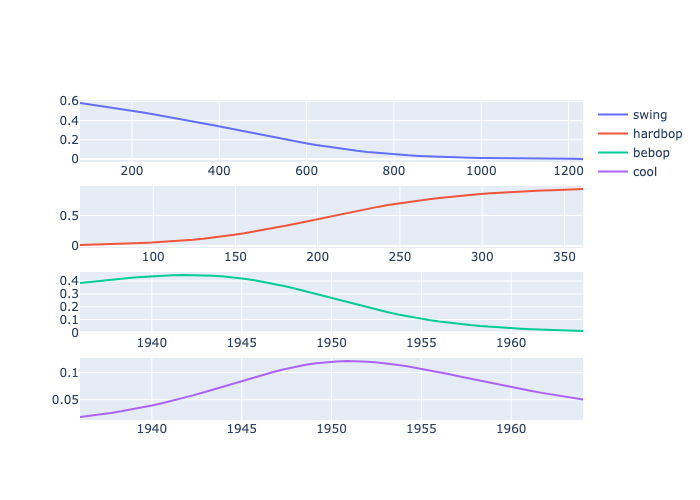

In [103]:
p=fit4.params.to_numpy()



x1 = np.linspace(test['tones'].min(),test['tones'].max())
x2 = np.linspace(test['tempo'].min(),test['tempo'].max())
x3 = np.linspace(test['year'].min(),test['year'].max())

exp1 = p[0,0]+p[1,0]*x1+p[2,0]*x2+p[3,0]*x3
exp2 = p[0,1]+p[1,1]*x1+p[2,1]*x2+p[3,1]*x3
exp3 = p[0,2]+p[1,2]*x1+p[2,2]*x2+p[3,2]*x3
predplot = make_subplots(rows=4,cols=1)

predplot.add_trace(go.Scatter(x=x1,y=(np.exp(exp1))/(1+np.exp(exp1)+np.exp(exp2)+np.exp(exp3)),name="swing"),row=1,col=1)
predplot.add_trace(go.Scatter(x=x2,y=(np.exp(exp2))/(1+np.exp(exp1)+np.exp(exp2)+np.exp(exp3)),name="hardbop"),row=2,col=1)
predplot.add_trace(go.Scatter(x=x3,y=(np.exp(exp3))/(1+np.exp(exp1)+np.exp(exp2)+np.exp(exp3)),name="bebop"),row=3,col=1)
predplot.add_trace(go.Scatter(x=x3,y=((1)/(1+np.exp(exp1)+np.exp(exp2)+np.exp(exp3))),name="cool"),row=4,col=1)
predplot.show("png")

In [104]:
test_dummies = pd.get_dummies(test['style'],dtype=float).to_numpy()

pred_dummies = np.zeros(np.shape(test_dummies))
for i in range(np.size(test_score)):
    for j in range(np.shape(pred_dummies)[1]):
        if test_score[i]==j:
            pred_dummies[i,j]=1

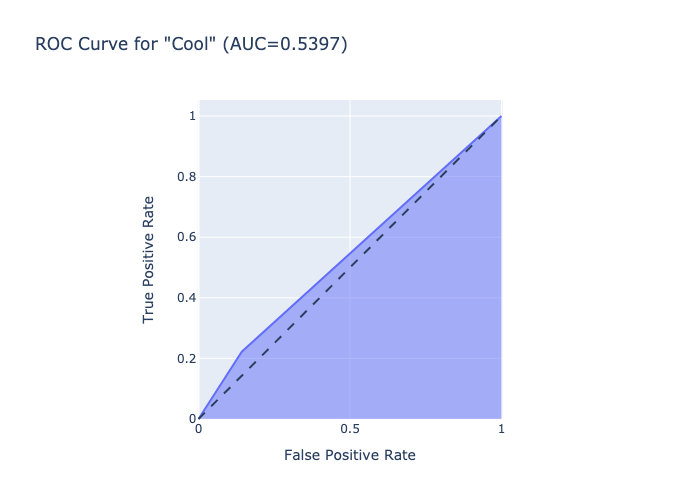

In [105]:
fpr0, tpr0, thresholds0 = roc_curve(test_dummies[:,0],pred_dummies[:,0])
figroc0 = px.area(
    x=fpr0, y=tpr0,
    title=f'ROC Curve for "Cool" (AUC={auc(fpr0, tpr0):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
figroc0.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

figroc0.update_yaxes(scaleanchor="x", scaleratio=1)
figroc0.update_xaxes(constrain='domain')
figroc0.show()

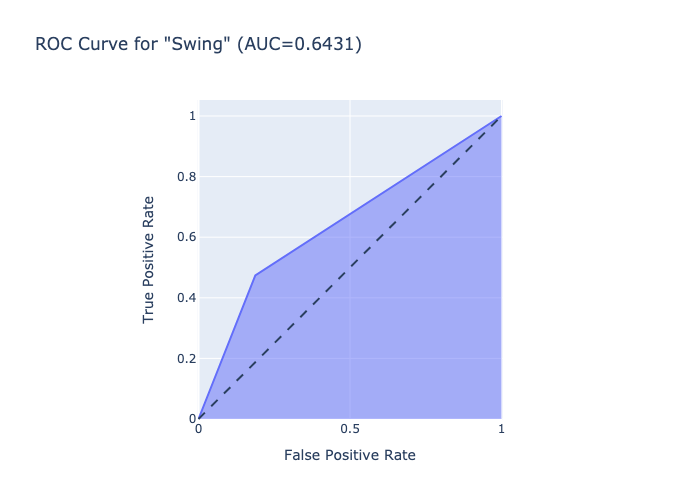

In [106]:
fpr1, tpr1, thresholds1 = roc_curve(test_dummies[:,1],pred_dummies[:,1])
figroc1 = px.area(
    x=fpr1, y=tpr1,
    title=f'ROC Curve for "Swing" (AUC={auc(fpr1, tpr1):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
figroc1.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

figroc1.update_yaxes(scaleanchor="x", scaleratio=1)
figroc1.update_xaxes(constrain='domain')
figroc1.show()

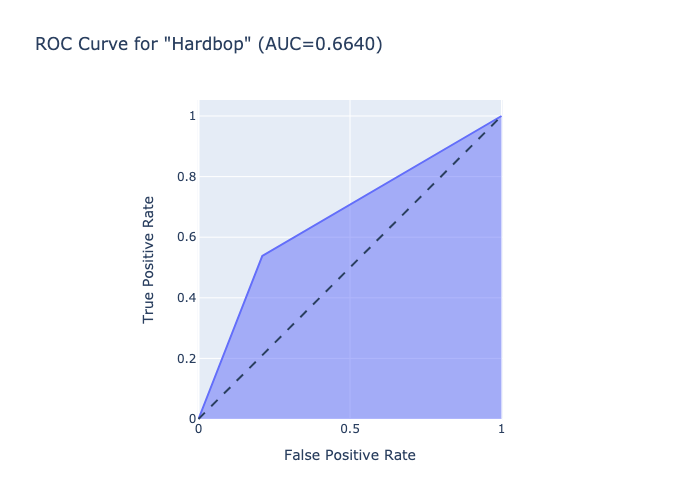

In [107]:
fpr2, tpr2, thresholds2 = roc_curve(test_dummies[:,2],pred_dummies[:,2])
figroc2 = px.area(
    x=fpr2, y=tpr2,
    title=f'ROC Curve for "Hardbop" (AUC={auc(fpr2, tpr2):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
figroc2.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

figroc2.update_yaxes(scaleanchor="x", scaleratio=1)
figroc2.update_xaxes(constrain='domain')
figroc2.show()

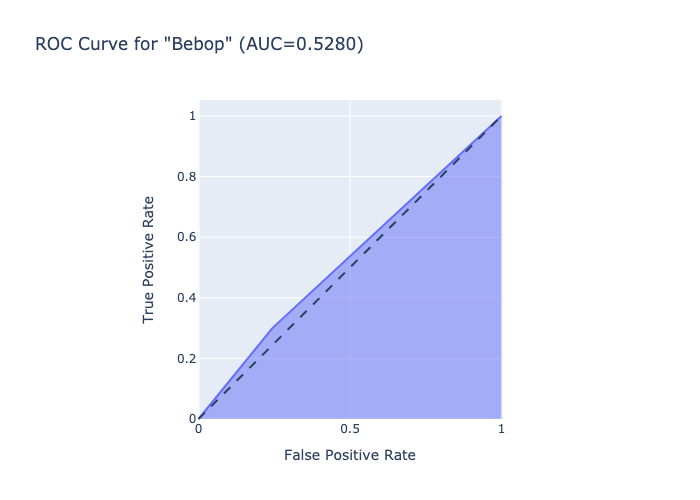

In [108]:
fpr3, tpr3, thresholds3 = roc_curve(test_dummies[:,3],pred_dummies[:,3])
figroc3 = px.area(
    x=fpr3, y=tpr3,
    title=f'ROC Curve for "Bebop" (AUC={auc(fpr3, tpr3):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
figroc3.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

figroc3.update_yaxes(scaleanchor="x", scaleratio=1)
figroc3.update_xaxes(constrain='domain')
figroc3.show()